# House Price Prediction

## Context

- This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.
<br>
- For the sake of simplicity, it may be better to perform the analysis as if it were the year that these houses were sold. This will remove the possible need to adjust the age of the houses for the current year (2024) and possibly even the need to adjust prices for inflation - assuming that meaningful insights were the goal. <br>
The data is the selling price of the homes in 2014/15 and this is more reflective of that current market price opposed to the homes underlying value. There are many other market factors that can effect this and will also need to be taken into consideration should a dataset this old be used for present day inferences. I think simplicity should prevail here. 

**Dataset:**<br>
<a href="https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/discussion?sort=undefined"> House Sales in King County, USA (Kaggle)</a> <br>
*note: In this project I am using a smaller version of this dataset with fewer features and instances.*
<br><br>

**Column Definitions:**<br>
id - Unique ID for each home sold <br>
date - Date of the home sale <br>
price - Price of each home sold <br>
bedrooms - Number of bedrooms <br>
bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower <br>
sqft_living - Square footage of the apartments interior living space <br>
sqft_lot - Square footage of the land space <br>
floors - Number of floors (0.5 = split-level or bi-level floors)<br>
waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not <br>
view - An index from 0 to 4 of how good the view of the property was <br>
condition - An index from 1 to 5 on the condition of the apartment <br>
grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design. <br>
sqft_above - The square footage of the interior housing space that is above ground level <br>
sqft_basement - The square footage of the interior housing space that is below ground level <br>
yr_built - The year the house was initially built <br>
yr_renovated - The year of the house’s last renovation <br>
zipcode - What zipcode area the house is in <br>
lat - Lattitude <br>
long - Longitude <br>
sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors <br>
sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors <br>

verified from 2 sources: <br>
https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices <br>
https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html

## Set up

In [1]:
import warnings
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, label_binarize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.feature_selection import SelectKBest, f_regression, f_classif

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# warnings.filterwarnings("ignore")
sns.set() 

In [2]:
data = pd.read_csv("../data/kc_house_data.csv")
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
0,221900.0,3,1.00,1180,5650,1.0,7,1180,0,1955,0,47.5112,-122.257,1340,5650,3
1,538000.0,3,2.25,2570,7242,2.0,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,3
2,180000.0,2,1.00,770,10000,1.0,6,770,0,1933,0,47.7379,-122.233,2720,8062,3
3,604000.0,4,3.00,1960,5000,1.0,7,1050,910,1965,0,47.5208,-122.393,1360,5000,5
4,510000.0,3,2.00,1680,8080,1.0,8,1680,0,1987,0,47.6168,-122.045,1800,7503,3


In [3]:
# Investigating the data's structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   grade          21613 non-null  int64  
 7   sqft_above     21613 non-null  int64  
 8   sqft_basement  21613 non-null  int64  
 9   yr_built       21613 non-null  int64  
 10  yr_renovated   21613 non-null  int64  
 11  lat            21613 non-null  float64
 12  long           21613 non-null  float64
 13  sqft_living15  21613 non-null  int64  
 14  sqft_lot15     21613 non-null  int64  
 15  condition      21613 non-null  int64  
dtypes: float64(5), int64(11)
memory usage: 2.6 MB


In [4]:
# Investigating simple summary statistics
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.401822e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652,3.409430
std,3.673622e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631,0.650743
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000,1.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000,3.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000,3.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000,4.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000,5.000000


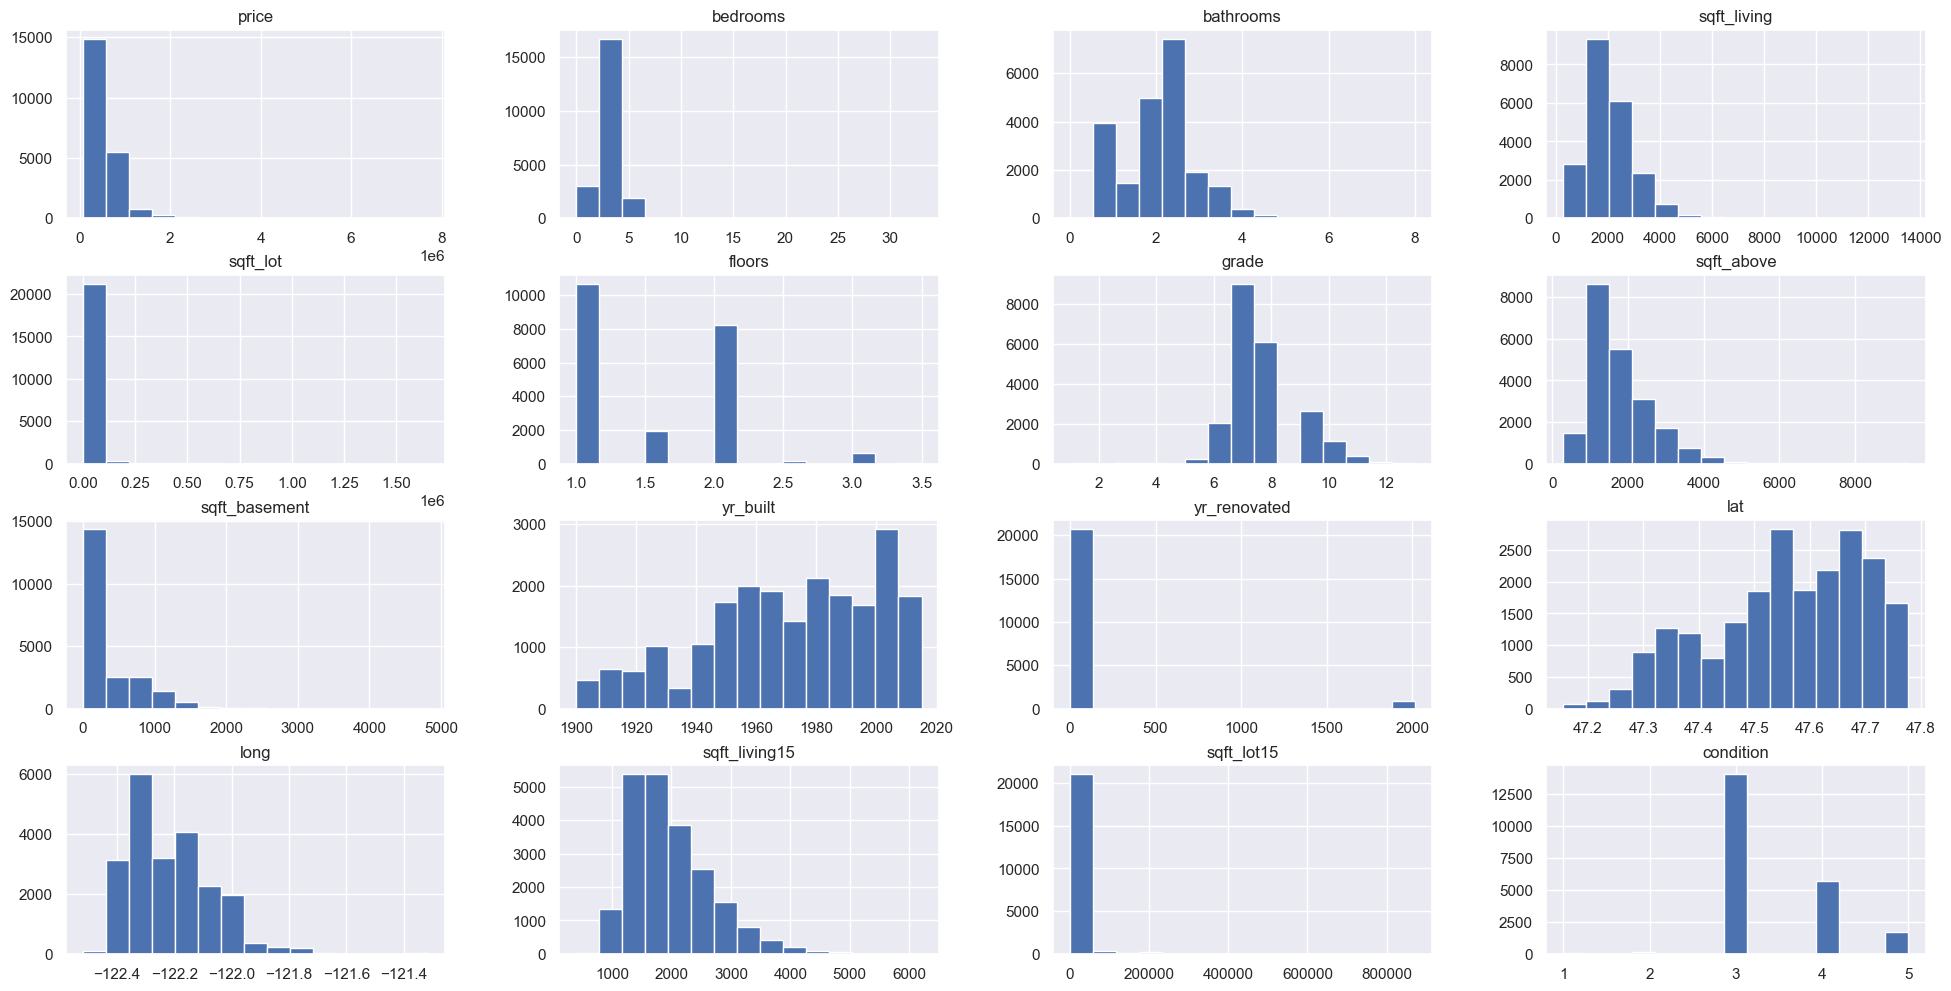

In [5]:
# Quick look at the distribution of all features
data.hist(bins=15, figsize=(24,12));

In [6]:
# Creating the train-test split before any further exploration to avoid any "data snooping" bias
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# A dataframe that contains both input and target features for ease of exploratory analysis
price_df = X_train.copy()
price_df[y_train.name] = y_train

## Exploratory Analysis

### General Exploration
For now, I will lead with curiosity and aim to develop a better sense of the data before looking for anything specific.

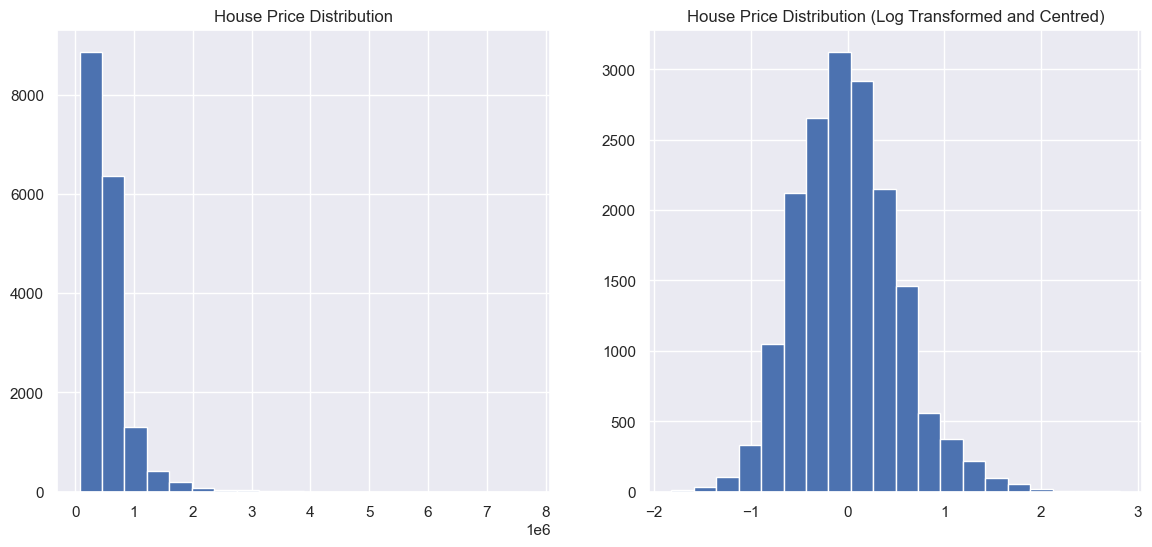

In [7]:
# Due to how positively skewed house prices are, a log transformation of the target variable may lead to improved model performance
# Below I am simply investigating the log transformed (and 0 centred) distribution of the house prices
price_log = np.log(price_df['price'])
price_log_centered = price_log - np.mean(price_log)

# Side by side plots of the price distribution and the transformed distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.hist(price_df['price'], bins=20)
ax2.hist(price_log_centered, bins=20)

ax1.title.set_text("House Price Distribution")
ax2.title.set_text("House Price Distribution (Log Transformed and Centred)")
plt.show();

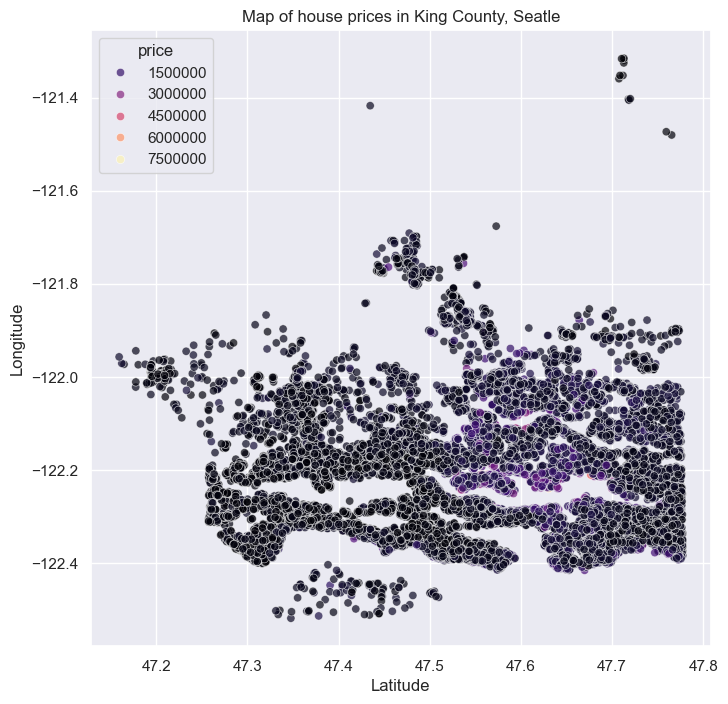

In [45]:
# Heat map of house prices relative to their location
# The highest priced houses that were sold seem to be concentrated around a particular area, however 
# this may not be a strong indication of any useful pattern that the model's can generalise to improve predictive power.

plt.figure(figsize=(8,8))
sns.scatterplot(data=price_df, x='lat', y='long', hue='price', 
                alpha=0.7, palette='magma')

plt.title("Map of house prices in Kings County, Seatle")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()

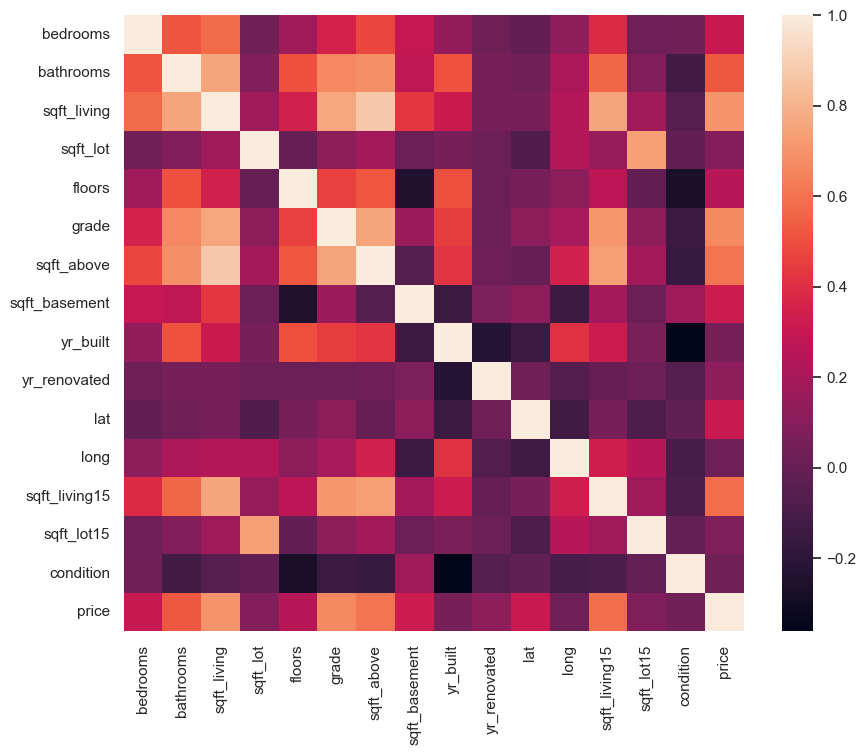

In [9]:
# Quick look at potentially interesting linear relationships between all variables
# There appears to be a high correlation between many of the independent variables such as bedrooms and bathrooms or sqft_living and sqft_living15. 
# This comes as no surprise but it may need to be considered when selecting features in order to improve model performance.
plt.figure(figsize=(10,8))
sns.heatmap(price_df.corr())

plt.show();

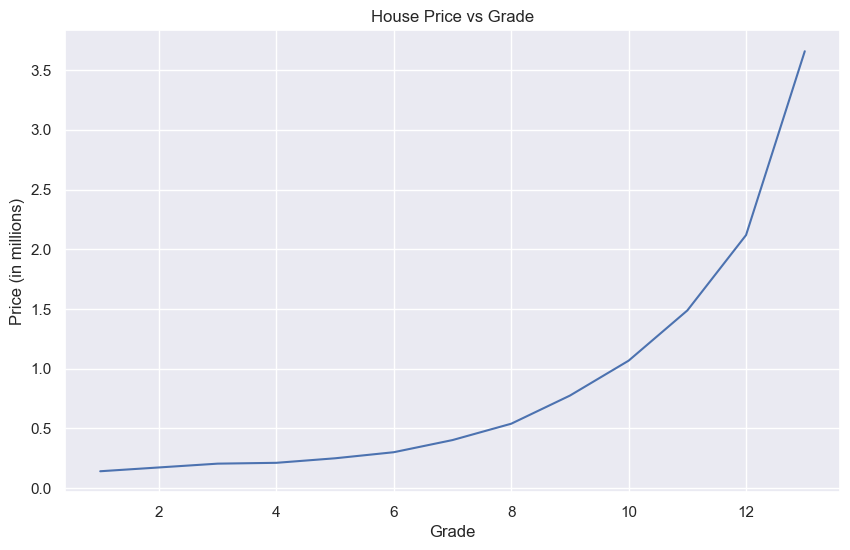

In [57]:
# Set the style
sns.set(style="darkgrid")

# Create a line plot for house price against grade, with y-axis scaled
plt.figure(figsize=(10, 6))
sns.lineplot(data=price_df, x="grade", y=price_df["price"] / 1_000_000, errorbar=None)

# Add labels and title
plt.xlabel("Grade")
plt.ylabel("Price (in millions)")
plt.title("House Price vs Grade")

# Display the plot
plt.show()

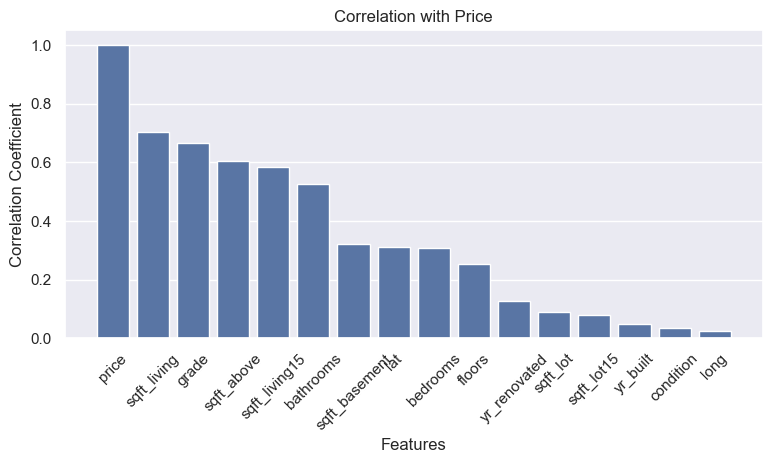

In [10]:
# Ordered bar chart of Pearson correlation coefs of each feature and the house price
# The features that are more closely correlated to the price variable are sqft_living, grade, sqft_above, and sqft_living15.
# sqft_living and sqft_above are highly correlated with each other (as expected as sqft_above is a component of sqft_living) 
# and may not be suitable for use together in the model.

corr_matrix = price_df.corr()[['price']].sort_values('price', ascending=False)

plt.subplots(figsize=(9,4))


sns.barplot(x=corr_matrix.index, y=corr_matrix['price'])
plt.title("Correlation with Price")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45)
plt.plot();

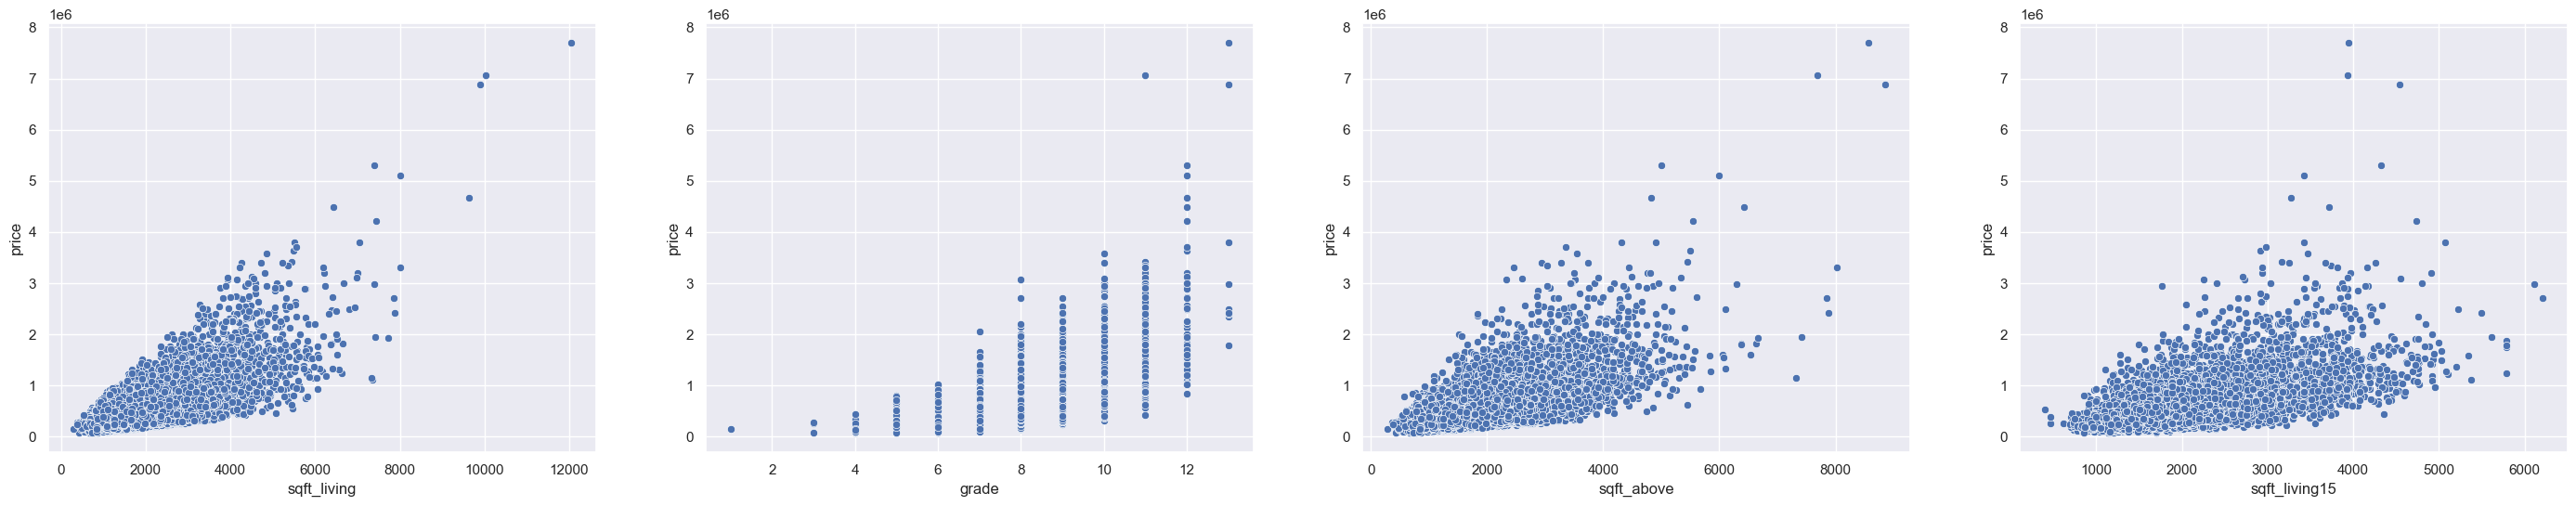

In [11]:
# Scatter plots of sqft_living, grade, sqft_above, and sqft_living15
fig, axs = plt.subplots(1, 4, figsize=(35,6))
plot_features = price_df[['sqft_living', 'grade', 'sqft_above', 'sqft_living15']].columns


for i, col in enumerate(plot_features):
    sns.scatterplot(data=price_df, x=col, y='price', ax=axs[i])

plt.show()

## Preprocessing & Feature Engineering
There are no missing values in the dataset and all categorical features are already numeric. Additionally, all of the numeric categorical features are ordinal so it would not be appropriate to one-hot encode them as this ordinal structure (e.g three bedrooms is more than two bedroom and the house price will be correlated to this relationship) is important. Some categorical values will still need some adjusting and other variables will require a few minor changes such as floats being converted into integers and so on. <br><br>
My initial round of preprocessing was performed without using scikit-learn's pipeline framework. However, for the sake of reproduceability across all of the models in this project I have since refactored that code into functions and classes that are compatible with the pipeline framework. Initially, this was very challenging as I ran into many bugs but it has been a worthwhile endeavour as it has streamlined the project structure and greatly improved my skills.

In [12]:
# Remove all outliers that fall outside of the specified threshold. 
# threshold=3 will remove all values that are more than 3 standard deviations from the mean
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold

    def fit(self, X, y=None):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        return self

    def transform(self, X, y=None):
        mask = np.abs((X - self.mean_) / self.std_) < self.threshold
        valid_rows = mask.all(axis=1)  # A series that evaluates to True for rows where all values are below threshold
        X_clean = X[valid_rows]
        y_clean = y[valid_rows]
        return (X_clean, y_clean)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X, y)

In [13]:
# All values for bathrooms will be rounded down as decimal values represent rooms with a toilet but no shower.
def round_down_int(X):
    '''Round all floats down before converting values into integer type (will be used solely for the 'bathroom' feature)'''
    return np.floor(X).astype(int)

round_down_transformer = FunctionTransformer(func=round_down_int)



# As homes with .5 floors are defined as split-level or bi-level floors they will be rounded up for simplicity
def round_nearest(X):
    '''Round all floats to nearest integer before converting values into integer type (will be used solely for the 'floors' feature)'''
    return np.round(X).astype(int)

round_transformer = FunctionTransformer(func=round_nearest)



# yr_built will be converted into 'age' (relative to the year of sale in 2015)
# I think it is more suitable to convert 'yr_built' into house age as the age will provide a clearer representation of a house's potential 
# condition or depreciation. There is also no time series component to the analysis/model. Furthermore, scaling the year_built will 
# likely lead to abstract values with little meaning.
def calculate_age(yr_built_column):
    '''Subtract all values from 2015 resulting in the age of the property at the time of sale (year 2015)'''
    return 2015 - yr_built_column

age_transformer = FunctionTransformer(func=calculate_age)



# 'yr_renovated' will be converted into binary variables stating whether the house has been renovated within a certain number of years
def renovated_within(yr_renovated_column):
    '''Calculate whether the property was renovated within the last 20, 10, and 5 years.'''
    
    # Calculate binary flags for different renovation periods
    renovated_20 = np.where(yr_renovated_column > 0, (2015 - yr_renovated_column) <= 20, False).astype(int)
    renovated_10 = np.where(yr_renovated_column > 0, (2015 - yr_renovated_column) <= 10, False).astype(int)
    renovated_5 = np.where(yr_renovated_column > 0, (2015 - yr_renovated_column) <= 5, False).astype(int)
    
    # Stack the arrays column-wise
    return np.column_stack((renovated_20, renovated_10, renovated_5))

yr_renovated_transformer = FunctionTransformer(func=renovated_within)

In [14]:
# Initially this custom transformer was built to be used within the below pipeline
# As scikit-learn's pipeline expects transformations to be applied to feature inputs only, I have struggled to build a custom transformer that will
# remove rows (where outliers are present) from both the input features and the target variable (to ensure their lengths are equal when piped 
# into the predictor). For this reason, I have removed outliers before implementing the pipeline.
# This unfortunately means that I cannot use GridSearchCV to evaluate different thresholds for outlier removal.
# However, this remains an opportunity for growth and possible model improvement in further iterations.

# Removing outliers with a custom transformer
outlier_remover = OutlierRemover(threshold=3)
X_train_clean, y_train_clean = outlier_remover.fit_transform(X_train, y_train)

In [15]:
# Preprocessing pipelines
age_pipeline = Pipeline([
    ('compute_age', age_transformer),
    ('scale', StandardScaler())
])


# Full preprocessing pipeline using ColumnTransformer to apply transformations seperately to relevant features
cont_features = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
                 'lat', 'long', 'sqft_living15', 'sqft_lot15'] 

full_preprocessing = ColumnTransformer([
    ('round_bathrooms', round_down_transformer, ['bathrooms']),
    ('round_floors', round_transformer, ['floors']),
    ('transform_age', age_pipeline, ['yr_built']),
    ('yr_renovated_binaries', yr_renovated_transformer, ['yr_renovated']),
    ('scale_cont', StandardScaler(), cont_features)
], 
    remainder='passthrough')

## Random Forrest Regression

In [16]:
# Random forest regressor pipeline
full_pipeline_rf = Pipeline([
    ('preprocessing', full_preprocessing),
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('random_forest', RandomForestRegressor(random_state=42))
])

# Hyperparameters to be used in the search
all_features = X_train_clean.shape[1]
param_grid_rf = {
    'feature_selection__k': [1, 4, 8, 12, all_features],
    'random_forest__n_estimators': [50, 100],
    'random_forest__max_depth': [10, 15, None],
    'random_forest__min_samples_split': [2, 5, 20],
    'random_forest__min_samples_leaf': [1, 5, 10],
    'random_forest__max_features': ['sqrt', 'log2', None]
}

# Implementing grid search CV
grid_search_rf = GridSearchCV(
    full_pipeline_rf,
    param_grid_rf,
    error_score='raise',
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=3
)

# Fit and output the best hyperparameters with corresponding best score
grid_search_rf.fit(X_train_clean, y_train_clean)
print(f"Best hyperparameters = {grid_search_rf.best_params_}")
print(f"Best score = {grid_search_rf.best_score_}")

Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Best hyperparameters = {'feature_selection__k': 15, 'random_forest__max_depth': None, 'random_forest__max_features': None, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 5, 'random_forest__n_estimators': 100}
Best score = 0.8380452820611138


### Analysis of Cross-Validation Scores

In [68]:
# Computing cross-validation scores using the best estimator
# Using more cv folds for greater reliability/accuracy as there is only one model being validated, unlike when searching for the best
# hyperparameters with GridSearchCV. (So I don't have to worry about my CPU melting)
cv_scores = cross_val_score(
    grid_search_rf.best_estimator_,
    X_train_clean,
    y_train_clean,
    cv=20, 
    scoring='r2'
)

# Cross-validation descriptive statistics
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
min_cv_score = np.min(cv_scores)
max_cv_score = np.max(cv_scores)

# Fit the model on the entire training set and compute training score
best_model = grid_search_rf.best_estimator_
best_model.fit(X_train_clean, y_train_clean)
train_score = r2_score(y_train_clean, best_model.predict(X_train_clean))

print(f"Cross-validation Mean Score: {mean_cv_score:.3f}")
print(f"Cross-validation Standard Deviation: {std_cv_score:.3f}")
print(f"Cross-validation Min Score: {min_cv_score:.3f}")
print(f"Cross-validation Max Score: {max_cv_score:.3f}")
print("")
print(f"Training Score: {train_score:.3f}")

if train_score > mean_cv_score:
    print(f"Training Score is higher than the Cross-validation Mean by {train_score - mean_cv_score:.2f}")
else:
    print(f"Training Score is lower than the Cross-validation Mean by {mean_cv_score - train_score:.2f}")

Cross-validation Mean Score: 0.840
Cross-validation Standard Deviation: 0.033
Cross-validation Min Score: 0.736
Cross-validation Max Score: 0.877

Training Score: 0.968
Training Score is higher than the Cross-validation Mean by 0.13


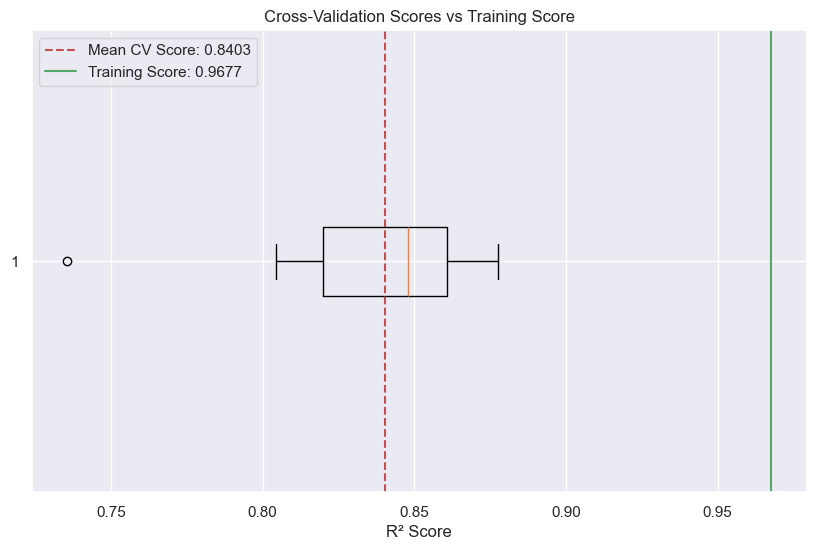

In [18]:
# Boxplot for cross-validation scores
plt.figure(figsize=(10, 6))

plt.boxplot(cv_scores, vert=False)
plt.axvline(mean_cv_score, color='r', linestyle='--', label=f'Mean CV Score: {mean_cv_score:.4f}')
plt.axvline(train_score, color='g', linestyle='-', label=f'Training Score: {train_score:.4f}')

plt.xlabel('R² Score')
plt.title('Cross-Validation Scores vs Training Score')
plt.legend()

plt.show()

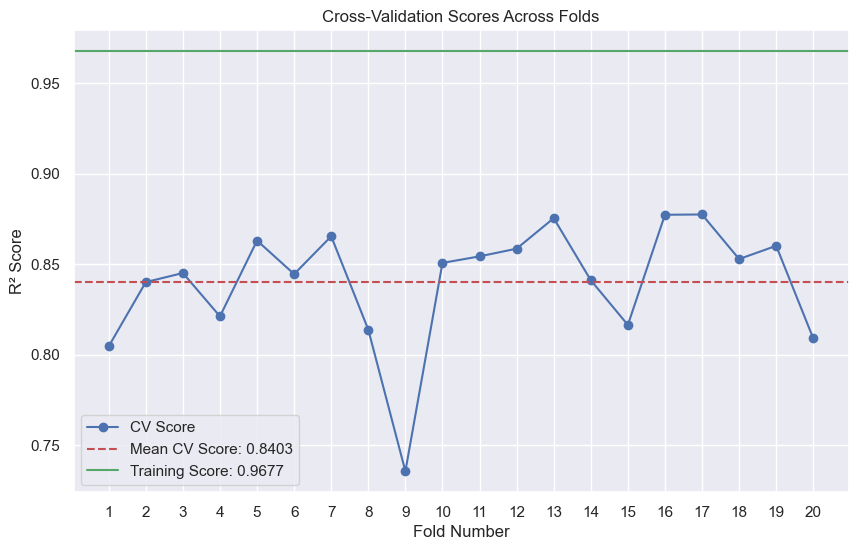

In [19]:
# Line plot for cross-validation scores
folds = np.arange(1, len(cv_scores) + 1)
plt.figure(figsize=(10, 6))
plt.grid(True)

plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='-', label='CV Score')
plt.axhline(mean_cv_score, color='r', linestyle='--', label=f'Mean CV Score: {mean_cv_score:.4f}')
plt.axhline(train_score, color='g', linestyle='-', label=f'Training Score: {train_score:.4f}')

plt.title('Cross-Validation Scores Across Folds')
plt.xlabel('Fold Number')
plt.ylabel('R² Score')

plt.xticks(folds)
plt.legend()

plt.show()

### Final Evaluation

In [67]:
# Best model from grid search
best_model_rf = grid_search_rf.best_estimator_

# Predict on the test set
y_pred_rf = best_model_rf.predict(X_test)

# Calculate evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Display metrics
print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"R-squared (R²): {r2_rf:.4f}")

Mean Squared Error (MSE): 32396675925.5113
Root Mean Squared Error (RMSE): 179990.7662
Mean Absolute Error (MAE): 80926.0358
R-squared (R²): 0.7860


### Notes:
